In [1]:
import arviz as az
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as scs
import itertools as iter
from IPython.display import display
from pytensor.printing import pydotprint
import pymc as pm
import pymc.math as pmm
import pytensor.tensor as pt
import pytensor as pt0
import pytensor.sparse as pts
import pytensor.d3viz as d3v
import math
import dtale
from whr.imports import *


%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")


%load_ext autoreload
%autoreload 2
import whr
from whr import *

%load_ext pyinstrument

In [2]:
print('Elo = natural rating * %.1f + 1500' % whr.eloPerNaturalRating)

Elo = natural rating * 173.7 + 1500


In [3]:
# g, gp = whr.readZklaBattles(whr.DEFAULT_MONTHS, doPreFilter=False)
# g[['is_autohost_teams', 'preFilter', 'is_teams', ]]

In [4]:
da = whr.PreprocessedData.load()

# print('-1 in first row for each player in varFrom* columns is expected.')
# da.playerDays

print(f'{len(da.games)} games; {len(da.gamePlayers)} gamePlayers; {len(da.playerDays)} playerDays')

25813 games; 354811 gamePlayers; 87236 playerDays


In [5]:
# da.games[da.games.day < np.datetime64('2021-01-01')]
da.games.assign(year = da.games.day.map(lambda d: d.year))[['year']].groupby('year').size()

year
2019     1057
2020     3324
2021     5670
2022    12067
2023     3695
dtype: int64

In [6]:
whr.setup_pytensor()

In [7]:
# onlyEvenGames = da.restrictGames(da.games.winnerCount == da.games.loserCount)
# evenModel = whr.createCumsumMatrixModel(onlyEvenGames, separateVirtualGames=True, useExtraPlayerAdjustment=False, useOutcomesPotential=False)

In [8]:
n=8000

In [9]:
unadjModel = whr.createUnadjustedCumsumMatrixModel(da)
if True:
    unadjModel.sample(draws=n//4)
    unadjModel.saveIData()
    unadjModel.calcAndSaveMAP()
else:
    unadjModel.loadIData()
    unadjModel.loadMAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [increments]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21949 seconds.


Sampling completed; extending perf stats


In [10]:
simpleAdjModel = whr.createSimpleAdjustedModel(da)
if True:
    simpleAdjModel.sample(draws=n//4)
    simpleAdjModel.saveIData()
else:
    simpleAdjModel.loadIData()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [increments, epadc]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22125 seconds.


Sampling completed; extending perf stats


In [11]:
bpstAdjModel = whr.createBPSTAdjustedModel(da)
if True:
    bpstAdjModel.sample(draws=n//4)
    bpstAdjModel.saveIData()
else:
    bpstAdjModel.loadIData()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [increments, epadc]


In [23]:
compareModels = dict(unadjModel=unadjModel, simpleAdjModel=simpleAdjModel, bpstAdjModel=bpstAdjModel)
for m in compareModels.values():
    if not 'log_likelihood' in m.idata:
        with m.model:
            m.compute_log_likelihood()

In [ ]:
loo = az.loo(unadjModel.idata, pointwise=True, var_name='Game outcomes')

In [87]:
loo

Computed from 8000 posterior samples and 22150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -14739.32    46.65
p_loo     2115.12        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     21947   99.1%
 (0.5, 0.7]   (ok)         183    0.8%
   (0.7, 1]   (bad)         20    0.1%
   (1, Inf)   (very bad)     0    0.0%

In [88]:
loo_df = pd.DataFrame(dict( \
   loo_i = loo.loo_i, # array of pointwise predictive accuracy, only if pointwise True
   pareto_k = loo.pareto_k
), index=da.games.index).assign(p = lambda df:  np.exp(df.loo_i))

loo_df[loo_df.pareto_k >= 0.7].join(da.gamePlayers).join(da.players, on='player').groupby('battle_id').apply(lambda g: pd.Series(dict(w = g[g.won][['name','playerDayCount']].to_numpy(), l = g[~g.won][['name','playerDayCount']].to_numpy()))).join(loo_df)

,w,l,loo_i,pareto_k,p
battle_id,,,,,
943959,"[[Qaa, 3]]","[[RealZener1, 1]]",-1.500005,0.793394,0.223129
952525,"[[SentinelComanche, 144]]","[[sMaxMd, 1]]",-0.126953,0.780867,0.880775
964378,"[[katastrophe, 286]]","[[venom69, 6]]",-1.064082,0.731339,0.345044
967752,"[[flipmedays, 4]]","[[MatthewGB, 42]]",-2.110805,0.777886,0.121140
1197373,"[[dings, 6]]","[[MrSiara, 55]]",-1.084915,0.890028,0.337930
1359271,"[[Notung, 252]]","[[WitherInc, 1]]",-0.017332,0.748502,0.982817
1368683,"[[Nor1kz, 1]]","[[kslv, 1]]",-0.655623,0.705639,0.519118
1384762,"[[hungdonkey, 19]]","[[Zeich, 16]]",-1.470663,0.819023,0.229773
1397812,"[[juanisafinehumanbeing, 22]]","[[TopGoodGame, 3]]",-0.342300,0.733323,0.710135


1-day player with rating x

1/(1+exp(-x)) * 1/(1+exp(x))
= 1/(1+exp(x)+exp(-x)+1)
= 1/(2+exp(x)+exp(-x))

P(y wins vs x) = \int 1/(1+exp(y-x)) 1/(2+exp(x)+exp(-x)) dx

In [96]:
len(da.playerDays)

73858

In [25]:
# compareDict = dict(unadjModel=unadjModel.idata, simpleAdjModel=simpleAdjModel.idata, bpstAdjModel=bpstAdjModel.idata)
cmp = az.compare({k : m.idata for k, m in compareModels.items()}, ic='loo', var_name='Game outcomes')
cmp

/home/daniel/dev/WHR/env/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning:

Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.

/home/daniel/dev/WHR/env/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning:

Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.

/home/daniel/dev/WHR/env/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
bpstAdjModel,0,-14662.093146,2116.534525,0.000000,0.673899,48.276185,0.000000,True,log
simpleAdjModel,1,-14667.054129,2118.937944,4.960982,0.175391,48.293260,6.328338,True,log
unadjModel,2,-14739.315606,2115.120891,77.222460,0.150711,46.646162,15.958799,True,log


In [26]:
print(f'Log score of always guessing 50%: {math.log(0.5):.4f}')
cmp.elpd_loo / len(simpleAdjModel.idata.observed_data['Game outcomes'])

Log score of always guessing 50%: -0.6931


bpstAdjModel     -0.661946
simpleAdjModel   -0.662169
unadjModel       -0.665432
Name: elpd_loo, dtype: float64

<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

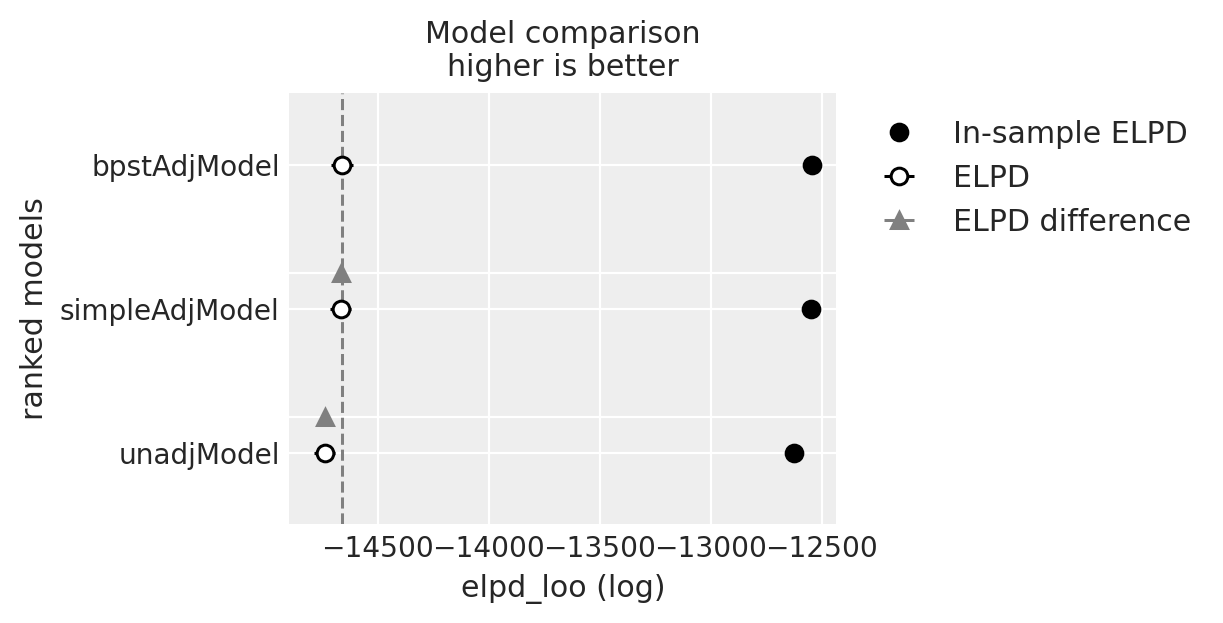

In [97]:
az.plot_compare(cmp, insample_dev=False)

In [ ]:
# idata.to_netcdf('even-games_cumsum-matrix-model-1-year.netcdf')
# idata.to_netcdf('cumsum-matrix-model-1-year.netcdf')

In [ ]:
# idata = az.InferenceData.from_netcdf('even-games_cumsum-matrix-model-1-year.netcdf')


In [ ]:
from IPython.display import HTML

perfStats = whr.loadPerfStats()
perfStats = pd.concat([DataFrame({'msPerSample': 1000 * perfStats.sampling_time / (perfStats.chains * perfStats.draws)} ) , perfStats], axis=1)
perfStats = perfStats[-50:]
HTML(perfStats.to_html())

^ PerfStats

In [ ]:
import xarray as xa
post = simpleAdjModel.idata.posterior
az.summary(xa.Dataset({
    'Extra player advantage [Elo]' : (whr.eloPerNaturalRating * post['epadc']), 
    # 'ratingClassCenter' : whr.naturalRatingToElo(post['ratingClassCenter']),
    # 'ratingClassSharpness' : post['ratingClassSharpness' ],
    'elo' : whr.naturalRatingToElo(post['ratings'])[:,:,100:110]
    }))

In [ ]:
post = bpstAdjModel.idata.posterior
az.summary(xa.Dataset({
    'Extra player advantage [Elo]' : (whr.eloPerNaturalRating * post['epadc']), 
    # 'ratingClassCenter' : whr.naturalRatingToElo(post['ratingClassCenter']),
    # 'ratingClassSharpness' : post['ratingClassSharpness' ],
    'elo' : whr.naturalRatingToElo(post['ratings'])[:,:,100:110]
    }))

In [ ]:
import xarray as xa
prior : xa.DataArray = pm.sample_prior_predictive(samples=8000//len(whr.advantageClasses), model=bpstAdjModel.model, var_names=['epadc']).prior.epadc
# prior = prior.stack(stacked=('draw','advc')).rename(draw='draw0').rename(stacked='draw').drop()
# prior = prior.rename(chain='z').rename(advc='chain')

az.plot_posterior(eloPerNaturalRating * prior, combine_dims={ 'chain','draw','advc','ratingclass' })

In [ ]:
import scipy.special

sampleElos = [1000,1500,2000,2500]


elos = np.linspace(0, 3500, 500)
plt.plot(elos, whr.models_shared.eloHighness(bpstAdjModel.idata, elos))
plt.xlabel('Elo')
plt.ylabel('Rating highness')

plotData = xa.Dataset({
    f'{advc} advantage [in Elo] - BPST = {elo} Elo (rh = {t:.2f})' : whr.eloPerNaturalRating * 
        ((1-t) * post['epadc'].sel(advc = advc, ratingclass=whr.ratingclassCoords[0], drop=True) \
            + \
         t     * post['epadc'].sel(advc = advc, ratingclass=whr.ratingclassCoords[1], drop=True)
        ) 
    for elo in sampleElos
    for t in [whr.models_shared.ratingHighness(bpstAdjModel.idata, elo)]
    for advc in whr.advantageClasses
    } 
    # | {
    # 'Prior (same for each)' : whr.eloPerNaturalRating * prior,
    # 'ratingClassCenter' : whr.naturalRatingToElo(post['ratingClassCenter']),
    # 'ratingClassSharpness' : post['ratingClassSharpness' ],
    # }
    )

az.plot_posterior(plotData, combine_dims={'chain','chain2','draw','draw2','advc2','rc2'}, hdi_prob=0.95, ref_val=0, grid=(len(plotData)//6+1,6))

# for x in [0.05,0.25,0.75,0.95]:
#     plotData[f'Elo at which a player is {100*x}% in the high rating class'] = \
#         whr.naturalRatingToElo(scipy.special.logit(x)/post['ratingClassSharpness' ] + post['ratingClassCenter'])
# plotData


In [ ]:
x = pt.matrix(dtype='float32')
pt0.function([x], [whr.smoothMaximum(x, axis=1, a=100)])(np.array([[0,0.05]], dtype='float32'))

In [ ]:
# pday = ()
# pday = (505371, np.datetime64('2023-04-30'))
models = [unadjModel,simpleAdjModel, bpstAdjModel]
modelLabels = ['unadj','simp','bpst' ]
whr.comparePlayerDay(models, 505371, np.datetime64('2023-04-30'), modelLabels)


PlayersWhoOftenPlayInUnevenGames = da.getPlayersWhoOftenPlayInUnevenGames(minTotal=10)

n=20
fig = plt.figure(figsize=(14,n))
prevAx = None

for i, pid in enumerate(PlayersWhoOftenPlayInUnevenGames.index[-n:]):
    ax = fig.add_subplot((n+1)//2,2,i+1, sharex=prevAx, sharey=prevAx)

    whr.comparePlayerDay(models, pid, -1, modelLabels, ax=ax)

    p = PlayersWhoOftenPlayInUnevenGames.loc[pid]
    ax.set_title(f'{p.nSmall}/{p.nTotal}', loc='left')
    prevAx=ax

# whr.comparePlayerDay(models, 522755, np.datetime64('2023-04-30'), modelLabels)
# whr.comparePlayerDay(models, 447183, np.datetime64('2023-04-13'), modelLabels)

In [ ]:
battleIds = post.coords['unevenGame(sts=2)']
highness : xa.DataArray = post['highRatingness(sts=2)']
bpr = post['smallerTeamBestPlayerRatings(sts=2)']

n = 12

def getSample(x):
    # return x.mean(['chain','draw'])
    return x[0,0]


ug = da.gamePlayers.join(\
        da.games.loc[battleIds[:n]].assign(
            highness = getSample(highness)[:n],
            bpr = getSample(bpr)[:n],
            bpelo = lambda df: whr.naturalRatingToElo(df.bpr),
            ), \
        how='right', on='battle_id', rsuffix='game_', validate='m:1') \
    .join(da.players, on='player', validate='m:1') \
    .set_index('won',append=True) \
    .swaplevel(2,1) \
    .sort_index() \
    .assign(rix = lambda df: df.join(simpleAdjModel.ratingIxLookup.to_frame('ix'), on=['player','day']).ix) \
    .assign(nrat = lambda df: getSample(post['ratings'][:,:,df.rix])) \
    .assign(elo = lambda df: whr.naturalRatingToElo(df.nrat)) \
    # .assign(elo = lambda df: model.ratingIxLookup[df.reset_index().set_index(['player','day']).index.to_numpy()]) \
ug[['day','name', 'highness', 'bpr',  'nrat', 'bpelo', 'elo']].assign(bpelomelo = lambda df: df.bpelo - df.elo)

In [ ]:
az.plot_posterior(whr.naturalRatingToElo(idata.posterior['ratings']), combine_dims={'chain','draw','playerDay'}, ref_val=1500)

In [ ]:
import IPython

mapRatings = mapRatings.join(da.players.name, how='left', on='player').droplevel('player').set_index('name', append=True) \

mapRatings['elo'] = whr.naturalRatingToElo(mapRatings.rating)

mapEloOut = mapRatings.elo.groupby('name').agg(['mean','median','first','max','min','last']).round(0)
mapEloOut['range'] = mapEloOut['max'] - mapEloOut['min']
# # IPython.display.HTML(eloOut.to_html())
regulars = da.players[da.players.playerDayCount > 15]

# IPython.display.HTML(mapEloOut.loc[regulars.name].sort_values('mean').to_html())
IPython.display.HTML(mapEloOut.sort_values('last',ascending=False)[:30].reset_index().to_html())

In [ ]:
import xarray as xa
ratingSamples : xa.DataArray = idata.posterior['ratings']

def plotPlayer(name, color, ax=None):
    testPlayerId = da.players[da.players.name==name].index[0]
    testPlayerIxs = simpleAdjModel.ratingIxLookup.loc[testPlayerId]
    testPlayerRatings = ratingSamples.isel(playerDay = testPlayerIxs)

    return az.plot_hdi(testPlayerIxs.index, whr.naturalRatingToElo(testPlayerRatings), smooth=False, ax=ax, color=color, fill_kwargs={'alpha': 0.1},
        plot_kwargs={'alpha':1}, hdi_prob=0.9)

ax = plotPlayer('Sab', 'red')
ax = plotPlayer('Kosynthary', 'green', ax)
ax = plotPlayer('mushroomraider', 'blue', ax)
ax = plotPlayer('Yeye77', 'yellow', ax)

In [ ]:
import xarray as xa





In [ ]:
# da.playerDays.groupby(level='player').apply(lambda g: g.iloc[[0,-1]])
postRatings = unadjModel.ratingsByPlayerDay()
ratingIxLookup = unadjModel.ratingIxLookup
gb = ratingIxLookup.groupby(level='player')
firstAndLastIx = gb.first().to_frame('firstIx').assign(lastIx = gb.last())
# firstAndLastIx

In [ ]:
firstLastRat = postRatings.isel(playerDay = firstAndLastIx.unstack()).assign_coords(
    fl = ('playerDay', np.fromiter(iter.chain(iter.repeat('first', len(firstAndLastIx)), iter.repeat('last', len(firstAndLastIx))),
                                    dtype="<U5", count=2*len(firstAndLastIx) ))
).drop_indexes(['playerDay','player','day']).set_xindex(['player','fl'])

hdi_prob = 0.95
ratingsHdiX : xa.Dataset = az.hdi(firstLastRat, hdi_prob=hdi_prob)
ratingsMeanX = firstLastRat.mean(dim=['chain','draw'])

In [ ]:
ratingStats : DataFrame = xa.concat([
    ratingsHdiX['ratings'].rename(hdi='stat'),
    ratingsMeanX.expand_dims(stat=['mean'], axis=-1)], dim='stat') \
    .to_dataframe(dim_order = ('stat','playerDay')) \
    .drop(columns = ['player', 'fl']).rename(columns = {'ratings':'rating'})

# ratingsHdi = ratingsHdi
ratingStats['Elo'] = whr.naturalRatingToElo(ratingStats.rating)

ratingStats = ratingStats.unstack(['fl','stat'])

# Remove date and name duplication for each stat
ratingStats = ratingStats.transpose().drop_duplicates().transpose().sort_index(axis=1).reorder_levels([1,0,2],1)

# ratingStats.columns = ratingStats.columns.to_flat_index()
# ratingStats.columns

# ratingStats = ratingStats.unstack('stat').assign(date = ratingsMeanX.coords['day'])

# ratingStats = ratingStats.unstack('fl').assign(name = ratingsMeanX.coords['name'] )

# grp = ratingStats.groupby(['player', 'fl'])
# assert (grp.day.min() == grp.day.max()).all()
# # assert (grp.name.min() == grp.name.max()).all()

# ratingStats = pd.concat([
#     DataFrame({
#         ('date',''): ratingStats.day.loc['mean'],
#     }),
#     ratingStats.drop(columns=['day']).unstack('stat')
#     ], axis=1)

# ratingStats = ratingStats.unstack('fl').reorder_levels([2,0,1], 1).sort_index(axis=1, ascending=[True,False,False]) \
#                 .rename(columns = {
#                     'lower':f'{100*hdi_prob:.0f}% HDI lower',
#                     'higher':f'{100*hdi_prob:.0f}% HDI upper'
#                 })

# ratingStats

In [ ]:
ratingStats.drop('rating', axis=1,level=1).sort_values(by=('last','Elo','mean'), ascending=False).set_index(('first','name','lower'), append=True).round(1)[:60]


In [ ]:
n = 50
az.plot_forest(
    firstLastRat.sel(playerDay = ratingsMeanX.sortby(ratingsMeanX, ascending=False)[:n].get_index('playerDay') ) \
        .set_index(playerDay = ('name', 'fl')).pipe(whr.naturalRatingToElo)
    
    ,
    combined=True)

In [ ]:
import IPython
postStats : DataFrame = postRatings.mean(dim=["chain", "draw"]).to_dataframe().drop(columns='player')
postMedians = postRatings.median(dim=["chain", "draw"])

postStats.index = unadjModel.ratingIxLookup.sort_values().index
postStats = postStats.set_index('name', append=True)

postStats = postStats.assign(mean_elo = whr.naturalRatingToElo(postStats.ratings),
                                 median_elo = whr.naturalRatingToElo(postMedians))

eloOut = postStats.mean_elo.groupby('name').agg(['mean','median','first','max','min','last']).round(0)
eloOut['range'] = eloOut['max'] - eloOut['min']
# IPython.display.HTML(eloOut.to_html())
regulars = da.players[da.players.playerDayCount > 9]

IPython.display.HTML(eloOut.sort_values('last',ascending=False)[:30].reset_index().to_html())

In [ ]:
comparison = DataFrame({
    'post_mean' : postStats.mean_elo, 
    'post_median' : postStats.median_elo, 
    'MAP' : mapRatings.elo}).sort_values('MAP', ascending=False)

comparison.reset_index().drop_duplicates('name').round(0)[:100]

In [ ]:
import matplotlib as mpl
import matplotlib.axes as mpla
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

axs = az.plot_forest(idata, var_names = '[Rr]ating', filter_vars="regex", combined=True)

ax : mpla.Axes =  axs[0]
ax.minorticks_on()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=5.0))
ax.xaxis.set_minor_locator(plticker.MultipleLocator(base=1.0))
ax.xaxis.set_tick_params(which='both', top=True, labeltop=True, bottom=True, labelbottom=True)
# ax.xaxis.set_tick_params(which='minor', grid_color='black', grid_linewidth=1, grid_alpha=1, grid_linestyle='-')
ax.xaxis.grid(True, which='major', color='black')
ax.xaxis.grid(True, which='minor')





# profileStats = basic_model.profile(basic_model.dlogp())
# profileStats.summary()
# fn = basic_model.compile_logp()
# pass
# az.plot_pair(idata, var_names = 'rating', filter_vars="like", kind='kde')

In [ ]:
pm.model_to_graphviz(simpleAdjModel.model)

In [ ]:
with simpleAdjModel.model:
    pm.compute_log_likelihood(idata, extend_inferencedata=False)

az.waic(idata)

In [ ]:
from IPython.display import SVG
from pytensor.printing import pydotprint

# postrw = idata.posterior["RW"]
# idata
# d3v.d3viz(basic_model.compile_logp().f, '/tmp/d3v.html')

# pydotprint(basic_model.compile_dlogp().f, format='svg')

# SVG(pt0.printing.pydotprint(basic_model.logp(), return_image=True, format='svg'))

pt0.dprint(basic_model.compile_logp().f, print_storage=True, print_view_map=False);

#az.plot_forest(idata)
# print(pt0.pp(basic_model.logp()))

In [ ]:
import xarray as xa
# az.plot_trace(idata, combined=True); #, coords={"RW_dim_0":range(1,5)});
postRatings : xa.DataArray = idata.posterior['ratings']
postRatings